In [1]:
# imports

import warnings
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import NearestNDInterpolator
import geopandas as gpd
import matplotlib.pyplot as plt
import GPUtil

from pykrige.ok import OrdinaryKriging
from skgstat import Variogram
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'

C:\Users\ranji\AppData\Local\Temp\ipykernel_2612\3304814055.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
df_train = pd.read_csv("data/bizinnovate-2023/train.csv")
df_test = pd.read_csv("data/bizinnovate-2023/test_masked.csv")

In [3]:
df_train.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,1,R,dhs_train/IA-2015-7-00010004.npz
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,1,R,dhs_train/IA-2015-7-00010005.npz
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,1,R,dhs_train/IA-2015-7-00010007.npz
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,1,R,dhs_train/IA-2015-7-00010016.npz
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,1,R,dhs_train/IA-2015-7-00010018.npz


In [4]:
# Read the feature data
column_names = ["lat", "lon", "n_asset", "asset_index", "sobel_pca1", "sobel_pca2", "sobel_pca3"]
X_train = pd.read_csv("features_extracted_from_cloud/feature_train.csv", names = column_names, header=0)
X_test = pd.read_csv("features_extracted_from_cloud/feature_test.csv", names = column_names, header = 0)

y_train = df_train["water_index"]


In [5]:
X_train.head()

,lat,lon,n_asset,asset_index,sobel_pca1,sobel_pca2,sobel_pca3
0,9.165413,92.742696,22.0,2.650768,-207.802754,-2.021971,-1.862787
1,8.307356,93.093792,22.0,2.157784,-196.246327,-60.889409,-23.256221
2,7.016968,93.893226,21.0,1.832751,-168.521367,-6.896665,-7.399880
3,9.194938,92.800432,22.0,2.746096,-131.789259,-40.208361,12.582586
4,8.055606,93.543892,22.0,2.581869,-204.735020,25.329997,9.203700


In [6]:
X_test.head()

,lat,lon,n_asset,asset_index,sobel_pca1,sobel_pca2,sobel_pca3
0,9.220903,92.781530,22.0,2.721812,-163.192395,-57.373432,-20.640230
1,7.028410,93.883430,20.0,2.287279,-167.549476,-12.247468,-7.414882
2,12.371448,92.783665,22.0,0.677109,-178.859001,23.990939,-43.986372
3,11.727304,92.719257,21.0,1.793683,-170.345962,43.655670,-23.180276
4,9.185310,92.777645,22.0,2.758168,-170.971692,-32.816367,19.304890


In [7]:
# Lets visualize the lat and lon for fun from the training dataframe

fig = px.scatter_mapbox(df_train, 
                        lat = "lat",
                        lon = "lon",
                        color="water_index",
                        size="water_index",
                        color_continuous_scale="RdYlGn_r",
                        zoom=3.5,
                        mapbox_style="carto-positron", hover_name="water_index")
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))

In [8]:
gdf_X_train = (gpd.GeoDataFrame(X_train,
                              crs = "EPSG:4326",
                              geometry = gpd.points_from_xy(X_train["lon"],
                                                            X_train["lat"])).to_crs("EPSG:3347")
              )

gdf_X_test = (gpd.GeoDataFrame(X_test,
                              crs = "EPSG:4326",
                              geometry = gpd.points_from_xy(X_test["lon"],
                                                            X_test["lat"])).to_crs("EPSG:3347")
              )

In [9]:
X_train["x_coord"], X_train["y_coord"] = gdf_X_train.geometry.x, gdf_X_train.geometry.y
X_test["x_coord"], X_test["y_coord"] = gdf_X_test.geometry.x, gdf_X_test.geometry.y

### Interpolation to estimate the water index over a grid

In [10]:
gdf_X_train.head()

,lat,lon,n_asset,asset_index,sobel_pca1,sobel_pca2,sobel_pca3,geometry
0,9.165413,92.742696,22.0,2.650768,-207.802754,-2.021971,-1.862787,POINT (2551907.049 15108041.751)
1,8.307356,93.093792,22.0,2.157784,-196.246327,-60.889409,-23.256221,POINT (2451664.804 15210695.801)
2,7.016968,93.893226,21.0,1.832751,-168.521367,-6.896665,-7.399880,POINT (2257888.199 15349398.107)
3,9.194938,92.800432,22.0,2.746096,-131.789259,-40.208361,12.582586,POINT (2545424.158 15100513.415)
4,8.055606,93.543892,22.0,2.581869,-204.735020,25.329997,9.203700,POINT (2371993.236 15220167.066)


In [11]:
resolution = 250000  # cell size in meters, smaller cell size = smaller pixel = higher resolution 
gridx = np.arange(gdf_X_train.bounds.minx.min(), gdf_X_train.bounds.maxx.max(), resolution)
gridy = np.arange(gdf_X_train.bounds.miny.min(), gdf_X_train.bounds.maxy.max(), resolution)

In [12]:
gdf_X_train.head()

,lat,lon,n_asset,asset_index,sobel_pca1,sobel_pca2,sobel_pca3,geometry
0,9.165413,92.742696,22.0,2.650768,-207.802754,-2.021971,-1.862787,POINT (2551907.049 15108041.751)
1,8.307356,93.093792,22.0,2.157784,-196.246327,-60.889409,-23.256221,POINT (2451664.804 15210695.801)
2,7.016968,93.893226,21.0,1.832751,-168.521367,-6.896665,-7.399880,POINT (2257888.199 15349398.107)
3,9.194938,92.800432,22.0,2.746096,-131.789259,-40.208361,12.582586,POINT (2545424.158 15100513.415)
4,8.055606,93.543892,22.0,2.581869,-204.735020,25.329997,9.203700,POINT (2371993.236 15220167.066)


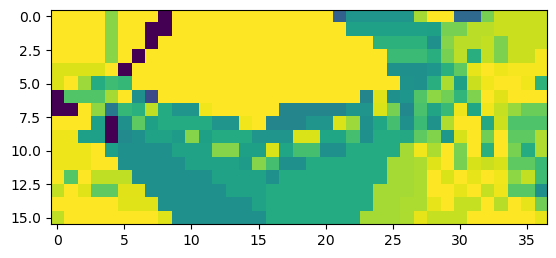

In [13]:
model = NearestNDInterpolator(x = list(zip(X_train["x_coord"], X_train["y_coord"])),
                              y = y_train)
z = model(*np.meshgrid(gridx, gridy))
plt.imshow(z);

The interpolation is pretty messy

### Creating a Variogram to see spatial autocorrelation

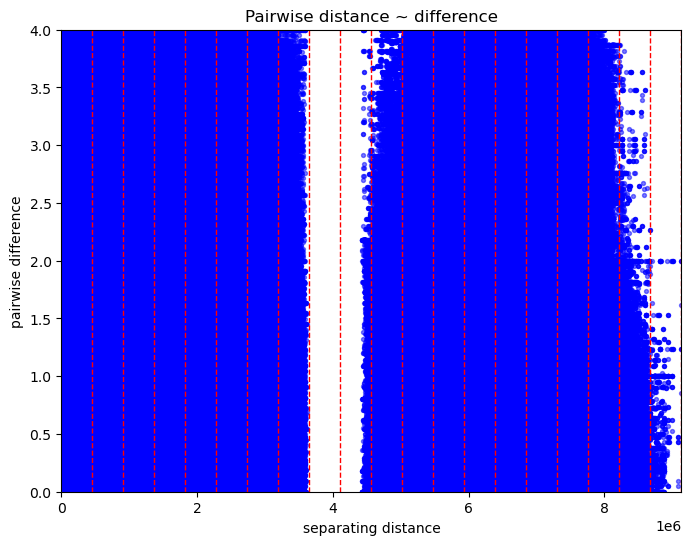

In [25]:
warnings.filterwarnings("ignore")  # Silence some warnings
vario = Variogram(coordinates=X_train[["x_coord", "y_coord"]].astype('float32'),
                  values=y_train,
                  n_lags=20)
vario.distance_difference_plot();

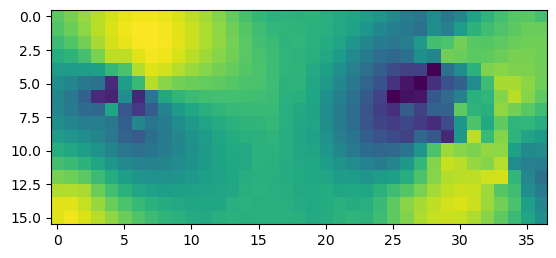

In [15]:
krig = OrdinaryKriging(x=X_train["x_coord"], y=X_train["y_coord"], z=y_train, variogram_model="spherical")
z, ss = krig.execute("grid", gridx, gridy)
plt.imshow(z);

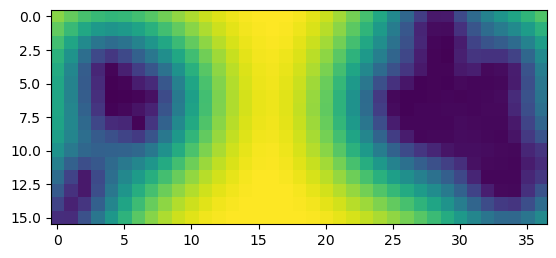

In [37]:
plt.imshow(ss);

TypeError: Invalid shape (18722,) for image data

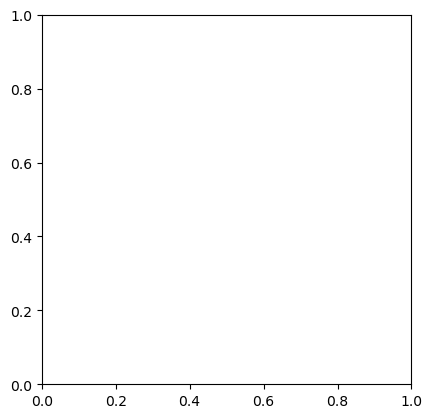

In [59]:
z_train, ss_train = krig.execute("points", X_train["x_coord"], X_train["y_coord"])

In [66]:
z_test, ss_test = krig.execute("points", X_test["x_coord"], X_test["y_coord"])

In [67]:
z_test

masked_array(data=[4.968648404118405, 4.895404645405417,
                   4.612592518196164, ..., 4.4839075450852866,
                   4.422129281541567, 4.399041631818637],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [80]:
# export the predictions
pd.DataFrame(z_test.data, columns = ['Krigging_prediction']).to_csv('Krigging_prediction.csv')
